In [1]:
import torch
import struct
from time import time
from collections import OrderedDict
import numpy as np
import scipy.stats
import pandas as pd
import pickle
import io
import binary_fractions
import matplotlib.pyplot as plt
from torch import nn, optim, rand
from torch.utils.data import DataLoader, ConcatDataset
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torchvision import datasets, transforms
from torchsummary import summary

Predefined values

In [2]:
DTYPE = torch.float32

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

Preparing Dataset 

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=DTYPE),
    transforms.Normalize([0.5], [0.5])
])

trainset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform,
)

testset = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform,
)

trainloader = DataLoader(
    dataset=trainset,
    batch_size=500,
    shuffle=False,
)

testloader = DataLoader(
    dataset=testset,
    batch_size=500,
    shuffle=False,
)

bothloader = DataLoader(
    dataset=ConcatDataset([trainset, testset]),
    batch_size=500,
    shuffle=False,
)

LeNet5 Model

In [4]:
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_stack = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, dtype=DTYPE),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Tanh(),
        nn.Conv2d(6, 16, kernel_size=5, stride=1, dtype=DTYPE),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Tanh(),
    )
    self.flatten = nn.Flatten()
    self.linear_stack = nn.Sequential(
        nn.Linear(400, 120, dtype=DTYPE),
        nn.Tanh(),
        nn.Linear(120, 84, dtype=DTYPE),
        nn.Tanh(),
        nn.Linear(84, 10, dtype=DTYPE)
    )

  def forward(self, x):
    x = self.conv_stack(x)
    x = self.flatten(x)
    x = self.linear_stack(x)
    return x

Model Training

In [5]:
def train(lenet5, trainloader, loss, optimizer):
  size = len(trainloader.dataset)
  lenet5.train()
  for batch, (X, y) in enumerate(trainloader):
    X, y = X.to(DEVICE), y.to(DEVICE)

    pred = lenet5(X)
    loss_value = loss(pred, y)

    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss_value, current = loss_value.item(), (batch) * len(X)
      print(f"loss: {loss_value:>7f} [{current:>5d}/{size:>5d}]")

In [6]:
def test(lenet5, testloader, loss):
  size = len(testloader.dataset)
  num_batches = len(testloader)
  lenet5.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
      for X, y in testloader:
          X, y = X.to(DEVICE), y.to(DEVICE)
          pred = lenet5(X)
          test_loss += loss(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [5]:
lenet5 = LeNet5()
print(lenet5.parameters)
lenet5 = lenet5.to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet5.parameters(), lr=0.001, momentum=0.9)

<bound method Module.parameters of LeNet5(
  (conv_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Tanh()
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Tanh()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Tanh()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)>


In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(lenet5, trainloader, loss, optimizer)
    test(lenet5, testloader, loss)
print("Done!")

Save trained model

In [11]:
torch.save(lenet5, './lenet5/lenet5_16.pth')

Load saved model

In [5]:
lenet5 = torch.load('./lenet5/lenet5_32.pth', map_location=DEVICE)

In [17]:
def main_test(lenet5, testloader):
  lenet5.eval()
  with torch.no_grad():
    predictions = torch.tensor([], dtype=torch.int, device=DEVICE)
    scores = torch.tensor([], device=DEVICE)
    for X, y in testloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      pred = lenet5(X)
      probs = nn.functional.softmax(pred, dim=1)
      output = torch.sort(probs, dim=1, descending=True)
      predictions = torch.cat((predictions, output[1]))
      scores = torch.cat((scores, output[0]))
    return (predictions, scores)

main_data_16 = main_test(lenet5, testloader)


In [18]:
main_data = pd.Series({
    'float32': main_data_32,
    'bfloat16': main_data_16,
})
main_data.to_pickle('./lenet5/lenet5_main_data.pkl')

In [8]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./lenet5/lenet5_main_data.pkl', 'rb') as f:
    main_data = CPU_Unpickler(f).load()


Fault Injection and Testing

In [6]:
class BinaryParam:
    def __init__(self, number: torch.Tensor=torch.tensor(0, dtype=torch.float)):
        self.number = number
        self.number_type = number.dtype
        if self.number_type == torch.bfloat16:
            self.conversion_types = ['FP16']
            self.default_conversion = 'FP16'
        elif self.number_type == torch.float32:
            self.conversion_types = ['FP32', 'FX32']
            self.default_conversion = 'FP32'

    def to_binary(self, conversion_type: str=None) -> str:
        if conversion_type is None:
            conversion_type = self.default_conversion
        if conversion_type not in self.conversion_types:
            raise TypeError('{} to {} conversion does not possible'.format(self.number_type, conversion_type))
        if conversion_type == 'FP16':
            return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', self.number.item())[:2])
        elif conversion_type == 'FP32':
            return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', self.number.item()))
        elif conversion_type == 'FX32':
            fx32_twos = binary_fractions.Binary(self.number.item()).to_twoscomplement()
            fx32_temp = binary_fractions.Binary(str(fx32_twos)).string.split('.')
            fx32_l = fx32_temp[0]
            fx32_lfilled = ''.join('{}'.format(fx32_l[0]) for i in range(10 - len(fx32_l))) + fx32_l[-10:]
            fx32_binary = fx32_lfilled + fx32_temp[1][:22]
            return fx32_binary
    
    def to_decimal(self, binary_str: tuple) -> torch.Tensor:
        if binary_str[1] not in self.conversion_types:
            raise TypeError('{} to {} conversion does not possible'.format(binary_str, self.number_type))
        if binary_str[1] == 'FP16':
            buffer = int(binary_str[0] + ''.zfill(16), 2).to_bytes(4, 'big')
            return self.number.fill_(struct.unpack('>f', buffer)[0])
        elif binary_str[1] == 'FP32':
            buffer = int(binary_str[0], 2).to_bytes(4, 'big')
            return self.number.fill_(struct.unpack('>f', buffer)[0])
        elif binary_str[1] == 'FX32':
            fx32_twos = binary_str[0][:10] + '.' + binary_str[0][10:]
            return self.number.fill_(binary_fractions.TwosComplement(fx32_twos).to_float())


In [7]:
def fault_injector(lenet5: LeNet5, conversion_type: str, selected_param: int=None, selected_bit: int=None):
    params_vector = parameters_to_vector(lenet5.parameters())
    if selected_param is None:
        selected_param = round(rand(1).item() * (len(params_vector) - 1))

    main_param = params_vector[selected_param].item()
    bi_param = BinaryParam(params_vector[selected_param])
    bi_str = bi_param.to_binary(conversion_type)
    if selected_bit is None:
        selected_bit = round(rand(1).item() * (len(bi_str) - 1))
    new_bi_str = list(bi_str)
    new_bi_str[selected_bit] = '1' if bi_str[selected_bit] == '0' else '0'
    new_bi_str = ''.join(new_bi_str)
    injected_param = bi_param.to_decimal((new_bi_str, conversion_type)).item()
    
    injected_lenet5 = LeNet5()
    injected_lenet5 = injected_lenet5.to(DEVICE)
    injected_lenet5.load_state_dict(lenet5.state_dict())
    vector_to_parameters(vec=params_vector, parameters=injected_lenet5.parameters())

    return injected_lenet5, main_param, injected_param


In [36]:
def test(lenet5, testloader):
  lenet5.eval()
  with torch.no_grad():
    predictions = torch.tensor([], dtype=torch.int, device=DEVICE)
    scores = torch.tensor([], device=DEVICE)
    for X, y in testloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      pred = lenet5(X)
      probs = nn.functional.softmax(pred, dim=1)
      output = torch.max(probs, 1)
      predictions = torch.cat((predictions, output[1]))
      scores = torch.cat((scores, output[0]))
    return (predictions, scores)
          

In [9]:
injected_data = pd.DataFrame(columns=['dtype', 'layer', 'param_number', 'bit_position', 'before_value', 'after_value', 'output'])


In [ ]:
layers_iteration = OrderedDict([(1, [1, 156])])
layers_iteration[2] = [round(241600 / 61706), 2416 + layers_iteration[1][1]]
layers_iteration[3] = [round(4812000 / 61706), 48120 + layers_iteration[2][1]]
layers_iteration[4] = [round(1016400 / 61706), 10164 + layers_iteration[3][1]]
layers_iteration[5] = [round(85000 / 61706), 850 + layers_iteration[4][1]]

conversion_type = 'FP16'
if conversion_type in ['FP32', 'FX32']:
    number_size = 32
elif conversion_type == 'FP16':
    number_size = 16
    
for layer in layers_iteration.keys():  
    if layer == 1:
        start_param = 0
    else:
        start_param = layers_iteration[layer - 1][1]
    end_param = layers_iteration[layer][1]
    
    for param_number in np.random.choice(np.arange(start_param, end_param), layers_iteration[layer][0], replace=False):
        start = time()
        for bit in range(number_size):
            injected_lenet, before_value, after_value = fault_injector(lenet5, conversion_type, param_number, bit)
            output = test(injected_lenet, testloader)
            info = {
                'dtype': conversion_type,
                'layer': layer,
                'param_number': param_number,
                'bit_position': bit,
                'before_value': before_value,
                'after_value': after_value,
                'output': output,
            }
            injected_data.loc[len(injected_data)] = info
            end = time()
        print('{:>0.4f}'.format((end - start)))


In [31]:
injected_data.to_pickle('./lenet5/lenet5_injected_data.pkl')

In [9]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./lenet5/lenet5_injected_data.pkl', 'rb') as f:
    injected_data = CPU_Unpickler(f).load()

In [13]:
injected_data.to_csv('./lenet5/lenet5_injected_data.csv')

In [ ]:
injected_data = pd.read_csv('./lenet5/lenet5_injected_data.csv')

In [33]:
print(injected_data.memory_usage(index=True).sum())
injected_data

704128


,dtype,layer,param_number,bit_position,before_value,after_value,output,sdc1,sdc5,sdc10p,sdc20p
0,FP32,1,128,0,0.411265,-4.112647e-01,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",2.38,0.01,6.84,4.88
1,FP32,1,128,1,0.411265,1.399461e+38,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",1.33,0.00,3.90,2.71
2,FP32,1,128,2,0.411265,2.229471e-20,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",0.39,0.00,1.72,0.91
3,FP32,1,128,3,0.411265,9.575503e-11,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",0.39,0.00,1.72,0.91
4,FP32,1,128,4,0.411265,6.275402e-06,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",0.39,0.00,1.72,0.91
...,...,...,...,...,...,...,...,...,...,...,...
7995,FP16,5,61559,11,0.156250,1.718750e-01,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",0.05,0.00,0.00,0.00
7996,FP16,5,61559,12,0.156250,1.640625e-01,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",0.05,0.00,0.00,0.00
7997,FP16,5,61559,13,0.156250,1.601562e-01,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",0.06,0.00,0.00,0.00
7998,FP16,5,61559,14,0.156250,1.582031e-01,"([tensor(7), tensor(2), tensor(1), tensor(0), ...",0.06,0.00,0.00,0.00


SDCs calculation

In [20]:
def sdc1(injected_outputs: pd.Series, main_outputs: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()
    for injection, value in injected_outputs.items():
        sdcs[injection] = (value[0] != main_outputs[:, 0]).type(torch.float).sum().item() * 100 / testset_length
    return pd.Series(sdcs)

def sdc5(injected_outputs: pd.Series, main_outputs: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()

    for injection, value in injected_outputs.items():
        testset_check = 0
        for test in range(testset_length):
            if value[0][test] not in main_outputs[test, :5]:
                testset_check += 1
        testset_check = testset_check / testset_length
        sdcs[injection] = testset_check * 100
    
    return pd.Series(sdcs)

def sdc10p(injected_outputs: pd.Series, main_outputs: torch.Tensor, main_scores: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()

    for injection, value in injected_outputs.items():
        testset_check = 0
        for test in range(testset_length):
            index = (main_outputs[test] == value[0][test]).nonzero(as_tuple=True)[0]
            ratio = value[1][test] / main_scores[test, index]
            if ratio > 1.1 or ratio < 0.9:
                testset_check += 1
        testset_check = testset_check / testset_length
        sdcs[injection] = testset_check * 100

    return pd.Series(sdcs)

def sdc20p(injected_outputs: pd.Series, main_outputs: torch.Tensor, main_scores: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()

    for injection, value in injected_outputs.items():
        testset_check = 0
        for test in range(testset_length):
            index = (main_outputs[test] == value[0][test]).nonzero(as_tuple=True)[0]
            ratio = value[1][test] / main_scores[test, index]
            if ratio > 1.2 or ratio < 0.8:
                testset_check += 1
        testset_check = testset_check / testset_length
        sdcs[injection] = testset_check * 100
    
    return pd.Series(sdcs)

def sdc10p_20p(injected_outputs: pd.Series, main_outputs: torch.Tensor, main_scores: torch.Tensor):
    sdcs1 = {}
    sdcs2 = {}
    testset_length = main_outputs.__len__()

    for injection, value in injected_outputs.items():
        testset_check1 = 0
        testset_check2 = 0
        for test in range(testset_length):
            index = (main_outputs[test] == value[0][test]).nonzero(as_tuple=True)[0]
            ratio = value[1][test] / main_scores[test, index]
            if ratio > 1.1 or ratio < 0.9:
                testset_check1 += 1
            if ratio > 1.2 or ratio < 0.8:
                testset_check2 += 1
        testset_check1 = testset_check1 / testset_length
        testset_check2 = testset_check2 / testset_length
        sdcs1[injection] = testset_check1 * 100
        sdcs2[injection] = testset_check2 * 100
    
    return pd.Series(sdcs1), pd.Series(sdcs2)

In [21]:
lenet5_sdc1 = sdc1(injected_data['output'][:3200], main_data['float32'][0])


SDC probability confidence interval

In [11]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    length = len(a)
    mean, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., length-1)
    return mean, h


Total SDC probability plot

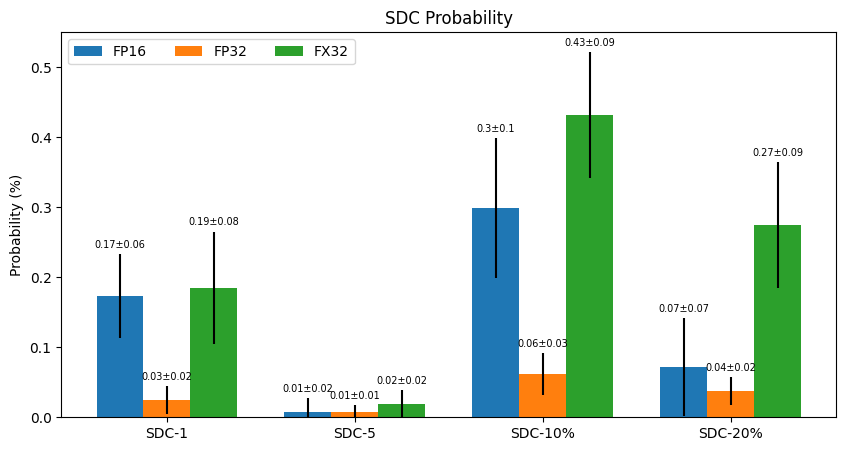

In [28]:
sdcs = {
    'FP16': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc20p']),
    ],
    'FP32': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc20p']),
    ],
    'FX32': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc20p']),
    ]
}

plt.figure(figsize=(10, 5))
plt.subplot()
width = 0.25

for i, (key, val) in enumerate(sdcs.items()):
    offset = width * i
    rects = plt.bar(np.arange(4) + offset, [m[0] for m in val], width, label=key, yerr=[np.round(m[1], 2) for m in val])
    plt.bar_label(rects, labels=['{}±{}'.format(np.round(m[0], 2), np.round(m[1], 2)) for m in val], fontsize=7, padding=3)

plt.ylabel('Probability (%)')
plt.title('SDC Probability')
plt.xticks(np.arange(4) + width, ['SDC-1', 'SDC-5', 'SDC-10%', 'SDC-20%'])
plt.legend(loc='upper left', ncols=3)
plt.ylim(0, 0.55)

plt.show()

Bit-wise SDC probability plot

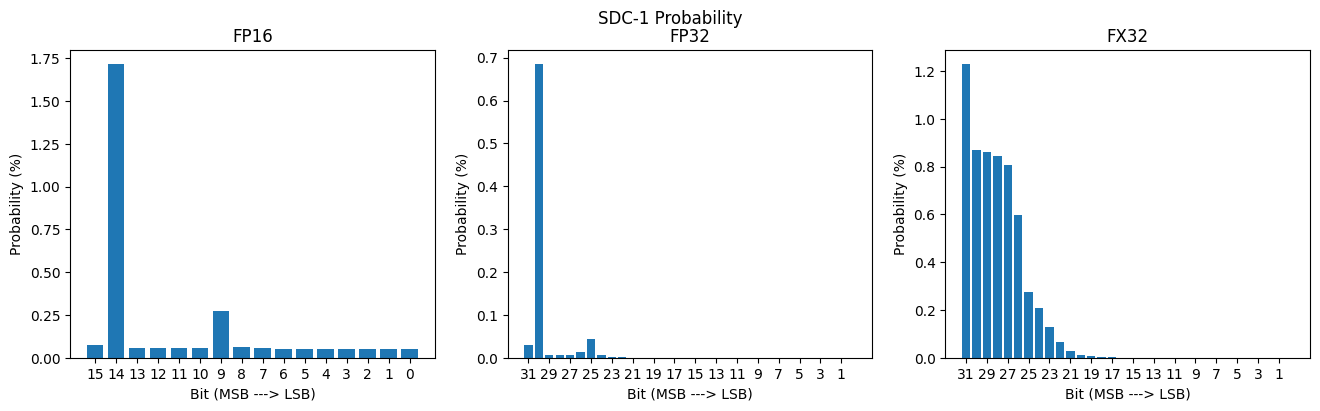

In [29]:
types_32 = np.arange(0, 32)
types_16 = np.arange(0, 16)
fp32_means = []
fx32_means = []
fp16_means = []
for i in types_32:
    mean_fp32_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FP32') & (injected_data['bit_position'] == i)]['sdc1'])
    fp32_means.append(mean_fp32_1)

    mean_fx32_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FX32') & (injected_data['bit_position'] == i)]['sdc1'])
    fx32_means.append(mean_fx32_1)

for i in types_16:
    mean_fp16_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FP16') & (injected_data['bit_position'] == i)]['sdc1'])
    fp16_means.append(mean_fp16_1)

plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title('FP16')
plt.bar((np.array(list(reversed(types_16)))).astype(str), fp16_means)
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')

plt.subplot(132)
plt.title('FP32')
plt.bar(types_32, fp32_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')

plt.subplot(133)
plt.title('FX32')
plt.bar(types_32, fx32_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')

plt.suptitle('SDC-1 Probability')
plt.show()


Layer-wise SDC probability plot

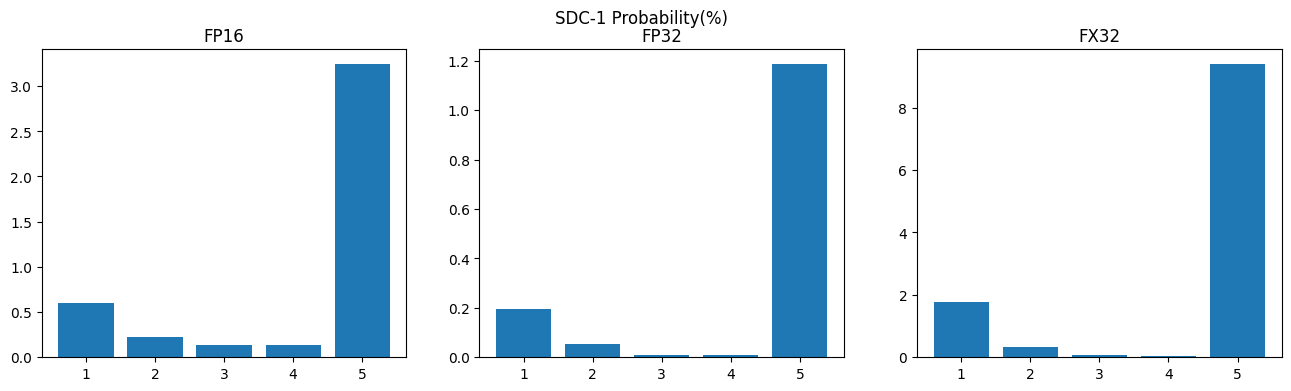

In [36]:
types = injected_data['layer'].drop_duplicates().to_list()
fp32_means = []
fx32_means = []
fp16_means = []
for i in types:
    mean_fp32_1, h = mean_confidence_interval(injected_data[(injected_data['dtype'] == 'FP32') & (injected_data['layer'] == i)]['sdc1'])
    fp32_means.append(mean_fp32_1)

    mean_fx32_1, h = mean_confidence_interval(injected_data[(injected_data['dtype'] == 'FX32') & (injected_data['layer'] == i)]['sdc1'])
    fx32_means.append(mean_fx32_1)

    mean_fp16_1, h = mean_confidence_interval(injected_data[(injected_data['dtype'] == 'FP16') & (injected_data['layer'] == i)]['sdc1'])
    fp16_means.append(mean_fp16_1)

plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title('FP16')
plt.bar(types, fp16_means)
plt.subplot(132)
plt.title('FP32')
plt.bar(types, fp32_means)
plt.subplot(133)
plt.title('FX32')
plt.bar(types, fx32_means)

plt.suptitle('SDC-1 Probability(%)')
plt.show()


Calculate range of layers

In [9]:
lenet5 = torch.load('./lenet5/lenet5_32.pth', map_location=DEVICE)

In [8]:
def get_range_hooks(lenet5, outputs: OrderedDict, input_size: list):
    def get_range(layer):
        def hook(module, input, output):
            layer_output = output.detach().clone()
            layer_min = torch.min(layer_output, dim=0)[0]
            layer_max = torch.max(layer_output, dim=0)[0]
            if layer not in outputs.keys():
                outputs[layer] = torch.stack([layer_min, layer_max], dim=-1)
            else:
                total_min = torch.minimum(outputs[layer][..., 0], layer_min)
                total_max = torch.maximum(outputs[layer][..., 1], layer_max)
                outputs[layer] = torch.stack([total_min, total_max], dim=-1)
        return hook

    def get_layers_by_index(layer_name):
        def hook(module, input, output):
            indexed_layers[(len(indexed_layers), layer_name)] = module
        return hook
    
    def get_layers(name: str, model: torch.nn.Module):
        children = list(model.named_children())
        return [(name, model)] if len(children) == 0 else [ci for c in children for ci in get_layers(name + '.' + c[0], c[1])]
    
    indexed_layers = OrderedDict()
    layers = get_layers('lenet5', lenet5)
    hooks = []
    for (layer, module) in layers:
        hooks.append(module.register_forward_hook(get_layers_by_index(layer)))

    X = [torch.rand(2, *input_size).type(DTYPE).to(DEVICE)]
    
    lenet5.eval()
    with torch.no_grad():
        lenet5(*X)
    
    for hook in hooks:
        hook.remove()

    hooks = []
    for key, module in indexed_layers.items():
        hooks.append(module.register_forward_hook(get_range(key)))
    
    return hooks

In [9]:
def find_layers_range(lenet5, testloader, outputs = None):
    if outputs is None:
        outputs = OrderedDict()
    total = len(testloader.dataset)
    hooks = get_range_hooks(lenet5, outputs, [1, 28, 28])
    lenet5.eval()
    with torch.no_grad():
        for i, (X, _) in enumerate(testloader):
            X = X.to(DEVICE)
            lenet5(X)
            print("{} / {}".format(len(X) * (i + 1), total))
        for hook in hooks:
            hook.remove()
    return outputs

In [ ]:
params_range = find_layers_range(lenet5, bothloader)

In [72]:
with open('./lenet5/lenet5_params_range.pkl', 'wb') as handle:
    pickle.dump(params_range, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./lenet5/lenet5_params_range.pkl', 'rb') as f:
    params_range = CPU_Unpickler(f).load()

SDC mitigation (Ranger)

In [10]:
lenet5 = torch.load('./lenet5/lenet5_32.pth', map_location=DEVICE)

In [11]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./lenet5/lenet5_injected_data.pkl', 'rb') as f:
    injected_data = CPU_Unpickler(f).load()

In [12]:
def ranger(lenet5, params_range: OrderedDict, result, input_size: list):
    def set_range(layer):
        def hook(model, input, output):
            layer_output = output.detach().to(DEVICE)
            bounded_layer = layer_output.clone().to(DEVICE)
            params_range_min = params_range[layer][..., 0].to(DEVICE)
            params_range_max = params_range[layer][..., 1].to(DEVICE)
            
            bounded_layer = torch.maximum(bounded_layer, params_range_min)
            bounded_layer = torch.minimum(bounded_layer, params_range_max)

            # enable when you want sdc detection
            #check_sdc = torch.eq(torch.flatten(bounded_layer, 1), torch.flatten(layer_output, 1))
            #result[0] = torch.logical_and(result[0], torch.all(check_sdc, dim=1))
            
            return bounded_layer
        return hook
    
    def get_layers_by_index(layer_name):
        def hook(module, input, output):
            indexed_layers[(len(indexed_layers), layer_name)] = module
        return hook
    
    def get_layers(name: str, model: torch.nn.Module):
        children = list(model.named_children())
        return [(name, model)] if len(children) == 0 else [ci for c in children for ci in get_layers(name + '.' + c[0], c[1])]
    
    indexed_layers = OrderedDict()
    layers = get_layers('lenet5', lenet5)
    hooks = []
    for (layer, module) in layers:
        hooks.append(module.register_forward_hook(get_layers_by_index(layer)))

    X = [torch.rand(2, *input_size).type(DTYPE).to(DEVICE)]
    
    lenet5.eval()
    with torch.no_grad():
        lenet5(*X)
    
    for hook in hooks:
        hook.remove()
    
    registered = []
    for key in params_range.keys():
        if key[0] in [1, 3, 5, 7, 10, 12]:
            registered.append(key)
            
            next_key = list(params_range.keys())[key[0] + 1]
            if next_key[0] in [2, 6, 8]:
                registered.append(next_key)
    registered.append(list(params_range.keys())[13])

    hooks = []
    for key in registered:
        hooks.append(indexed_layers[key].register_forward_hook(set_range(key)))

    return hooks

In [13]:
def detector_forward(lenet5, testloader, batch_result):
    lenet5.eval()   
    with torch.no_grad():
        predictions = torch.tensor([], dtype=torch.int, device=DEVICE)
        scores = torch.tensor([], device=DEVICE)
        result = torch.tensor([], dtype=torch.bool, device=DEVICE)
        inf_time = 0
        for X, _ in testloader:
            batch_result[0] = torch.full((len(X),), True).to(DEVICE)
            X = X.to(DEVICE)
            start = time()
            pred = lenet5(X)
            inf_time += (time() - start)
            probs = nn.functional.softmax(pred, dim=1)
            output = torch.max(probs, 1)
            predictions = torch.cat((predictions, output[1]))
            scores = torch.cat((scores, output[0]))
            result = torch.cat((result, batch_result[0]))
        return (predictions, scores), result, inf_time

In [14]:
def detector_test(lenet5, testloader, injected_data, params_range, cushion):
    new_params_range = OrderedDict()
    for layer, params in params_range.items():
        layer_min = torch.add(params[..., 0], torch.abs(params[..., 0]), alpha=-cushion)
        layer_max = torch.add(params[..., 1], torch.abs(params[..., 1]), alpha=cushion)
        new_params_range[layer] = torch.stack([layer_min, layer_max], dim=-1)
    
    for layer, params in new_params_range.items():
        new_params_range[layer] = torch.tensor([torch.min(params[..., 0]), torch.max(params[..., 1])], dtype=DTYPE)
    
    detector_data = pd.DataFrame(columns=['output', 'detected', 'runtime'])
    for i, row in injected_data.iterrows():
        injected_lenet, _, _ = fault_injector(lenet5, row['dtype'], row['param_number'], row['bit_position'])

        batch_result = [0]

        hooks = ranger(injected_lenet, new_params_range, batch_result, [1, 28, 28])

        detector_data.at[i, 'output'], detector_data.at[i, 'detected'], detector_data.at[i, 'runtime'] = detector_forward(injected_lenet, testloader, batch_result)        
        
        for hook in hooks:
            hook.remove()
        
        print("index: {}, SDC detected: {} %, runtime: {}".format(i, 100 * (1 - detector_data.at[i, 'detected'].sum().item() / len(testloader.dataset)), detector_data.at[i, 'runtime']))
    return detector_data
        

In [ ]:
ranger_output = detector_test(lenet5, testloader, injected_data[:3200], params_range, 0)

In [17]:
ranger_output.to_pickle('./lenet5/lenet5_ranger_test.pkl')

In [18]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./lenet5/lenet5_ranger_test.pkl', 'rb') as f:
    ranger_output = CPU_Unpickler(f).load()
